In [1]:
# Install pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

from utils.preprocessing import get_dataset_partitions_tf

In [3]:
print(f"TensorFlow version: {tf.__version__}")
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
Num GPUs Available: 0
GPUs Available: []


In [4]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Loading data
We would like to load our images in the resoultion 256x256.
We also would like to load them in batches of 32. Loading 32 images then another 32 and so on.
## Constants

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3  # The RGB channels
EPOCHS = 50

The `image_dataset_from_directory` function will load all the images in the folder `data/` and its subfolders

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE    
)
dataset

Found 2152 files belonging to 3 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

When images are loaded they are automatically sorted in classes. The classes are the names of the subfolders where the were found.

In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

**The images were loaded in 68 datasets**

------------------

`dataset.take(1)` takes 1 batch from the dataset and returns a list of tuple of the images in a batch and the labels of those images.
> Since the argument of take is 1, there will be only one iteration

(32, 256, 256, 3)
[0 1 1 0 1 1 1 2 1 1 1 0 1 1 2 1 0 1 1 1 0 0 1 0 1 2 1 1 1 1 1 1]


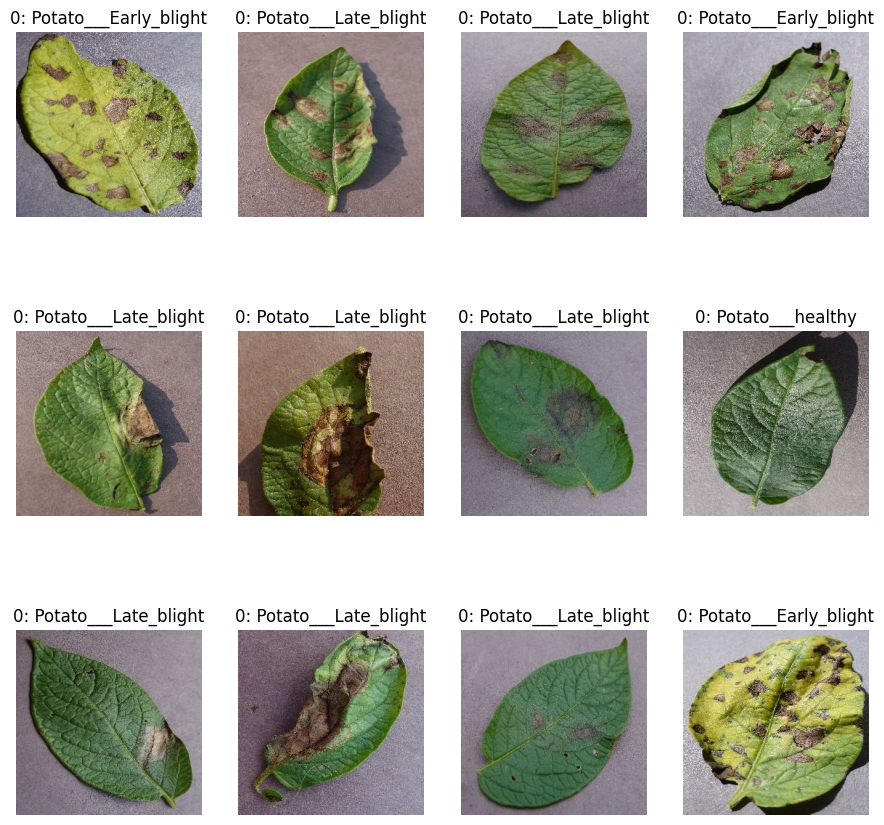

In [9]:
plt.figure(figsize=(11, 11))  # Let's resize the plot so that we can fit more pictures

for image_batch, label_batch in dataset.take(1): 
    print(image_batch.shape)
    print(label_batch.numpy())

    # Let's show the first 12 image in the batch
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # Choose the position where to plot in a grid of 3 lines and 4 columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # We need to convert to unisigned int of size 8 for it to plot properly
        plt.title("{}: {}".format(label_batch[0], class_names[label_batch[i]]))  # tile is "class number: class name"
        plt.axis("off")  # Remove the axes of the plot. They are not needed when showing an image

**(32, 256, 256, 3) : 32 is the size of the first batch. 256, 256 is the size of the images. 3 are the RGB channels**

# Split Data
We will split our data as follows:

* 70% training data
* 15% cross validation data
* 15% test data

After each epoch, we test our model in the cross validation set and improve it.

After `EPOCHS` number of epochs, we test our model against the test data set.

In [10]:
train_size = 0.7  # 70%
batches_in_training = int(train_size * len(dataset))  # How many batches will be in the training set
batches_in_training

47

In [11]:
# Get the training dataset
train_ds = dataset.take(batches_in_training)

In [12]:
# Get the rest of the batches that were not in the trainining dataset
tmp_test_ds = dataset.skip(batches_in_training)  

In [13]:
cv_size = 0.15  # 15%
batches_in_cv = int(cv_size * len(dataset))
batches_in_cv

10

In [14]:
cv_ds = tmp_test_ds.take(batches_in_cv)  # Training data set takes the number of batches `batches_in_cv`
test_ds = tmp_test_ds.skip(batches_in_cv)  # Test data set takes the rest of the batches

We could get the same result using the function `get_dataset_partition_tf` from the local `utils` package:

In [15]:
train_ds, cv_ds, test_ds = get_dataset_partitions_tf(dataset, train_split=0.7, cv_split=0.15)

In [16]:
len(train_ds)

47

In [17]:
len(cv_ds)

10

In [18]:
len(test_ds)

11

# Prefetch and Cache
Prefetching and caching are techniques used to speed up the training of the model.
They are better explained in the following video:ions



In [19]:
%%HTML
<div align="center">
    <iframe width="560" height="315" 
    src="https://www.youtube.com/embed/MLEKEplgCas?si=nGLgGDZUVV2Fbr3M">
    </iframe>
</div>

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
cv_ds = cv_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing Layers
We'll create 2 small neural networs (we call layers) that will provide resize, rescaling and data augmentation.

## Resize & Rescale:

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Once the model is implemented in the wild, it won't necessarily be fed images of size 256x256
    layers.experimental.preprocessing.Rescaling(1.0/255),  # This layer is added to scale all the features to values between 0 and 1
])

## Data Augmentation
Data Augmentation is a technique used to grow the size of our dataset wihtout having to seek new data. It's well explained in this video:

In [22]:
%%HTML
<div align="center">
    <iframe width="560" height="315" 
    src="https://www.youtube.com/embed/mTVf7BN7S8w?si=ZnGl7BCc7PNhT5-a">
    </iframe>
</div>

Here is the layer (neural network) for data augmentation:

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  # Flip randomly
    layers.experimental.preprocessing.RandomRotation(0.3)  # The factor of rotation (0.3 of a full rotation in either direction)
])

# Convolutional Network

Let's create our model including:
* The above 2 preprocessing layers
* A convolutional network
* A dense network
* An output layer

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = tf.keras.Sequential([
    # Preprocessing
    resize_and_rescale,
    data_augmentation,

    # Convolutional Network
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flattening the output of the convolutional network
    layers.Flatten(),

    # Dense neural network to make calculations
    layers.Dense(64, activation='relu'),

    # Output layer
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train the model
# After each epoch, run the cross validation to improve its accuracy
t1 = time.time()
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=cv_ds
)
t2 = time.time()

Epoch 1/50
47/47 [==============================] - 70s 1s/step - loss: 0.9205 - accuracy: 0.4781 - val_loss: 0.8196 - val_accuracy: 0.5031
Epoch 2/50
47/47 [==============================] - 61s 1s/step - loss: 0.7130 - accuracy: 0.6596 - val_loss: 0.6762 - val_accuracy: 0.8031
Epoch 3/50
47/47 [==============================] - 63s 1s/step - loss: 0.4671 - accuracy: 0.8112 - val_loss: 0.3495 - val_accuracy: 0.8531
Epoch 4/50
47/47 [==============================] - 63s 1s/step - loss: 0.2863 - accuracy: 0.8743 - val_loss: 0.1674 - val_accuracy: 0.9406
Epoch 5/50
47/47 [==============================] - 63s 1s/step - loss: 0.2055 - accuracy: 0.9282 - val_loss: 0.2196 - val_accuracy: 0.9031
Epoch 6/50
47/47 [==============================] - 65s 1s/step - loss: 0.2349 - accuracy: 0.9089 - val_loss: 0.1334 - val_accuracy: 0.9531
Epoch 7/50
47/47 [==============================] - 62s 1s/step - loss: 0.1395 - accuracy: 0.9461 - val_loss: 0.0989 - val_accuracy: 0.9469
Epoch 8/50
47/47 [==

In [ ]:
print("Training duration", t2 - t1)

### Let's test the model on the test dataset

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

### Let's plot the accuracy on the training dataset and CV dataset after each epoch

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Let's see how the model predicts one image

In [ ]:
for images_batch, labels_batch in test_ds.take(1):  # This will iterate only once
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Prediction Output:", batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Inference function

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # output shape of img_array is [1, 256, 256, 3]
    # print(img_array.shape.as_list())  
    
    predictions = model.predict(img_array, verbose=0)  # Tensorflow has its way to transform it to [32, 256, 256, 3] to do its calculations

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
### Let's predict the classes 9 random images

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Let's save the model

In [ ]:
import os
# Increase the version of the model at each save.
# Each model will be in a subfolder of the folder `models`
model_version = max([int(i) for i in os.listdir("./models") + [0]]) + 1

# Save the mode
model.save(f"./models/{model_version}")